In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
import matplotlib
import seaborn as sns
import sys
import os
from os import path
import yaml
import copy
from scipy import stats
from importlib import reload  

In [4]:
os.chdir('../..')

In [5]:
from mega_analysis.crosstab.mega_analysis.MEGA_ANALYSIS import MEGA_ANALYSIS
from mega_analysis.Sankey_Functions import normalise_localisation_cols_OTHER_SplitTL
from mega_analysis.crosstab.mega_analysis.QUERY_SEMIOLOGY import QUERY_SEMIOLOGY
from mega_analysis.crosstab.NORMALISE_TO_LOCALISING_VALUES import NORMALISE_TO_LOCALISING_VALUES
from mega_analysis.crosstab.file_paths import file_paths
from mega_analysis.crosstab.lobe_top_level_hierarchy_only import top_level_lobes
from mega_analysis.crosstab.hierarchy_dictionaries import temporal_postcodes
from mega_analysis.semiology import recursive_items

In [537]:
from scripts.figures import interogate_queries, labels
from scripts.figures  import plotter_functions

In [541]:
reload(plotter_functions)

<module 'scripts.figures.plotter_functions' from '/Volumes/Encrypted/Semiology-Visualisation-Tool/scripts/figures/plotter_functions.py'>

# Define lists & file paths

In [11]:
repo_dir, resources_dir, excel_path, semiology_dict_path = file_paths()

Semio2Brain_Database = r'/Volumes/Encrypted/Semiology-Visualisation-Tool/resources/__Semio2Brain Database v1.1.0.xlsx'

with open(semiology_dict_path) as f:
    SemioDict = yaml.load(f, Loader=yaml.FullLoader)

In [329]:
region_names = labels.get_region_names()

In [18]:
semiology_list = list(recursive_items(SemioDict))

semiology_list_automatism_removed = semiology_list
automatism_subcategories = ['Automatism - Automotor Manual','Automatisms - Oral', 'Mimetic Automatisms', 'Automatism - Lower Limb - Non Hypermotor']
for subcategory in automatism_subcategories:
    semiology_list_automatism_removed.remove(subcategory)

# Get df from Excel sheet & query df

In [20]:
(original_df, 
df_ground_truth, df_study_type,
num_database_articles, num_database_patients, num_database_lat, num_database_loc) = \
                MEGA_ANALYSIS(Semio2Brain_Database)
print(original_df.shape)

(2576, 121)


In [277]:
df = copy.deepcopy(original_df)
raw_dfs = {
    'full': df,
    'spontaneous': df[df['Spontaneous Semiology (SS)'] == 'y'],
    'topology':  df[df['Spontaneous Semiology (SS)'] != 'y'],
}

In [59]:
def query_semiology_wrapper(df, semiology_list, semiology_dict_path):
    query_results = {}
    for semiology in semiology_list:
        query_inspection, num_query_lat, num_query_loc = QUERY_SEMIOLOGY(df,
                                                                     semiology_term=semiology,
                                                                     ignore_case=True,
                                                                     semiology_dict_path=semiology_dict_path,
                                                                     all_columns_wanted = True)
                                                                             # col1=col1, col2=col1)
            
        one_query_result = {
            'query_inspection': query_inspection,
            'num_query_lat': num_query_lat,
            'num_query_loc': num_query_loc
        }
        query_results[semiology] = one_query_result
    return query_results

In [278]:
query_results_not_normalised = {}
for key, df in raw_dfs.items():
    query_results_not_normalised[key] = query_semiology_wrapper(df, semiology_list_automatism_removed, semiology_dict_path)

In [279]:
normalised_df = normalise_localisation_cols_OTHER_SplitTL(copy.deepcopy(original_df))[0]
normalised_raw_dfs = {
    'full': normalised_df,
    'spontaneous': normalised_df[normalised_df['Spontaneous Semiology (SS)'] == 'y'],
    'topology':  normalised_df[normalised_df['Spontaneous Semiology (SS)'] != 'y'],
}

In [280]:
normalised_raw_dfs = {}
for key, df in raw_dfs.items():
    normalised_raw_dfs[key] = normalise_localisation_cols_OTHER_SplitTL(df)[0]

In [281]:
query_results_normalised = {}
for key, df in normalised_raw_dfs.items():
    query_results_normalised[key] = query_semiology_wrapper(df, semiology_list_automatism_removed, semiology_dict_path)

In [ ]:
# normalised_df[region_names['all']].sum(0)

In [282]:
query_results = {
    'not_normalised': query_results_not_normalised,
    'normalised': query_results_normalised,
}

In [283]:
def sort_semiologies_by_n(query_result, top_n = 0, include_n = False):
    """
    Get semiologies in order of most frequently seen, based on query results
    
    Input:
    - query_results: a dictionary where keys are semiologies and values are
    'query_inspection' for that semiology, as returned by QUERY_SEMIOLOGY
    (often query_results['not_normalised']['full'])
    - top_n can be used to get the n semiologies with the highest number of cases
    - include_n = True to return the frequency of each semiology
    """
    n_results = []
    for k, v in query_result.items():
        n_results.append(v['num_query_loc'])
    n_results = np.array(n_results)
    
    labels = list(query_result.keys())
    sorted_result = np.sort(n_results)
    sorted_index = np.argsort(n_results)
    sorted_labels = [labels[i] for i in sorted_index]
    if include_n:
        return tuple(zip(sorted_labels[-top_n:], sorted_result[-top_n:]))
    else:
        return sorted_labels[-top_n:]

In [284]:
sorted_semiologies = sort_semiologies_by_n(query_results['not_normalised']['full'])

---
# Figure 1 - proportions by semiology
---

In [228]:
plt.rc('font', size=8)          # controls default text sizes
plt.rc('axes', titlesize=9)     # fontsize of the axes title
plt.rc('axes', labelsize=9)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=7)    # fontsize of the tick labels
plt.rc('ytick', labelsize=7)    # fontsize of the tick labels
plt.rc('legend', fontsize=7)    # legend fontsize
plt.rc('figure', titlesize=10) 

In [83]:
legend_labels = ['ALl studies', 'Spontaneous Semiology only']
# colors = ['#009988', '#cc3311'] # green, red
colors = [sns.color_palette("Greys")[3], sns.color_palette()[0]] # greys
# colors =  [(0.5085736255286428, 0.5085736255286428, 0.5085736255286428, 0.5), matplotlib.colors.colorConverter.to_rgba('black', alpha=.5)] #greys, transparent
# colors = [sns.color_palette("Greens")[3], sns.color_palette("Greens")[5]] # greens
# colors = [sns.color_palette("Greys")[4], sns.color_palette("Greens")[5]] # grey-greens
plotter_settings = {
    'ls': 'none',
    'linewidth': 1,
    'marker': 'o',
    'markeredgewidth': 1,
    'markersize': 3.5,
#     'markerfacecolor': 'white',
#     'alpha': 0.5
}

In [331]:
axis='semiology'
regions_of_interest = region_names['of_interest_minus_tl']+region_names['low_level_temporal_of_interest']
semiologies_of_interest = sorted_semiologies[-12:]

processed_dfs = {}
for normalised_or_not, sub_query_results in query_results.items():
    processed_dfs[normalised_or_not] = {}
    for study_type, query_result in sub_query_results.items():
        processed_dfs[normalised_or_not][study_type] = interogate_queries.summarise_query(
            query_result,
            axis = 'semiology',
            region_names = region_names,
            confint_method = 'binomial',
            merge_temporal = False,
            other_regions_included = True,
            semiologies_of_interest = semiologies_of_interest,
            regions_of_interest = regions_of_interest,
            drop_other_semiology = True)

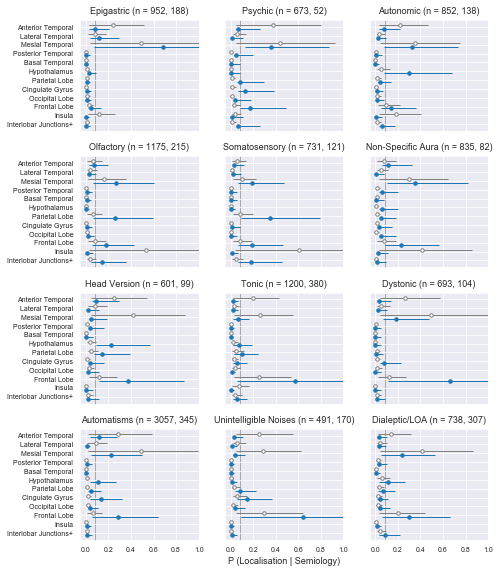

In [332]:
sns.set_style('darkgrid')
plot_proportion_ci_forest_plot(proportion_df_1 = processed_dfs['normalised']['full']['proportion'],
                               confint_df_1 = processed_dfs['normalised']['full']['confints'],
                               counts_df_1 = processed_dfs['not_normalised']['full']['counts'],
                               colors = colors,
                               legend_labels = legend_labels,
                               proportion_df_2 = processed_dfs['normalised']['spontaneous']['proportion'],
                               confint_df_2 = processed_dfs['normalised']['spontaneous']['confints'],
                               counts_df_2 = processed_dfs['not_normalised']['spontaneous']['counts'],
                               y_labels = labels.clean_localisations(processed_dfs['normalised']['full']['proportion'].columns),
                               overlapping=False,
                               ax_titles = labels.clean_semiologies(processed_dfs['normalised']['full']['proportion'].index),
                               plotter_settings = plotter_settings,
                              )

# plt.savefig('.png', dpi=300, pad_inches=0.5)

_______
# Figure 2: By zone
________

In [102]:
def plot_stacked_hbar(proportions_df, ax, ax_title=None, axis='semiology', y_labels=None, color_palette = sns.color_palette("Paired", 12, as_cmap=True)):
    if y_labels is not None:
        proportions_df.columns = y_labels
        
    if axis=='semiology':
        proportions_df=proportions_df
        xlabel = 'P(Localisation | Semiology)'
    elif axis=='zone':
        proportions_df=proportions_df.T
        xlabel = 'P(Semiology | Localisation)'
    else:
        raise ValueError('axis kwarg must be from {semiology, zone}')
    
    proportions_df[::-1].plot(kind='barh', colormap=color_palette, stacked=True,figsize=(10, 4), ax=ax)
    plt.gca().set_xlim((0,1))

    ax.title.set_text(ax_title)
    ax.set_xlabel(xlabel)

In [352]:
regions_of_interest = region_names['of_interest_minus_tl']+region_names['low_level_temporal_of_interest']
semiologies_of_interest = sorted_semiologies[-20:]
axis = 'zone'

processed_dfs = {}
for normalised_or_not, sub_query_results in query_results.items():
    processed_dfs[normalised_or_not] = {}
    for study_type, query_result in sub_query_results.items():
        processed_dfs[normalised_or_not][study_type] = interogate_queries.summarise_query(query_result,
                                                                      axis = axis,
                                                                      region_names = region_names,
                                                                      confint_method = 'binomial',
                                                                      merge_temporal = False,
                                                                      other_regions_included = True,
                                                                      semiologies_of_interest = semiologies_of_interest,
                                                                      regions_of_interest = regions_of_interest,
                                                                      drop_other_semiology = False)

In [343]:
y_sums_1 = [int(n) for n in processed_dfs['not_normalised']['full']['counts'].sum(0)]
y_sums_2 = [int(n) for n in processed_dfs['not_normalised']['topology']['counts'].sum(0)]

combine_labels_1 = [label+f' (n={n})' for n, label in zip(y_sums_1, labels.clean_localisations(processed_dfs['not_normalised']['full']['counts'].columns))]
n_labels_1 = [f'n={n}' for n in y_sums_1]
n_labels_2 = [f'n={n}' for n in y_sums_2]

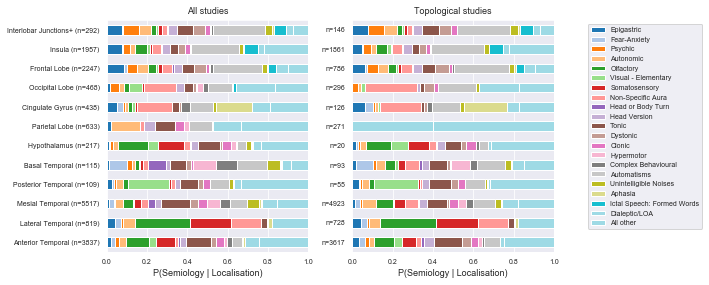

In [353]:
sns.set_style('darkgrid')
# color_palette = sns.color_palette("Paired", 12, as_cmap=True)
color_palette =  sns.color_palette("tab20", as_cmap=True)

fig, axs = plt.subplots(1, 2, sharex=True, sharey=False,)

plot_stacked_hbar(processed_dfs['normalised']['full']['proportion'], ax=axs[0],
                  ax_title='All studies', axis=axis, color_palette=color_palette)
plot_stacked_hbar(processed_dfs['normalised']['topology']['proportion'], ax=axs[1],
                  ax_title='Topological studies', axis=axis, color_palette=color_palette)

axs[0].get_legend().remove()
axs[0].set_yticklabels(combine_labels_1)
axs[1].set_yticklabels(n_labels_2)
axs[1].legend(bbox_to_anchor=(1.15,1), loc="upper left", labels=labels.clean_semiologies(processed_dfs['normalised']['topology']['proportion'].index))

plt.tight_layout()
# plt.savefig('/Users/karan/Downloads/fig2_stacked_by_zone_all_other_normalise.png', dpi=300, pad_inches=0.5)

In [338]:
reload(labels)

<module 'scripts.figures.labels' from '/Volumes/Encrypted/Semiology-Visualisation-Tool/scripts/figures/labels.py'>

/Users/karan/anaconda3/envs/semiology-vis/lib/python3.9/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


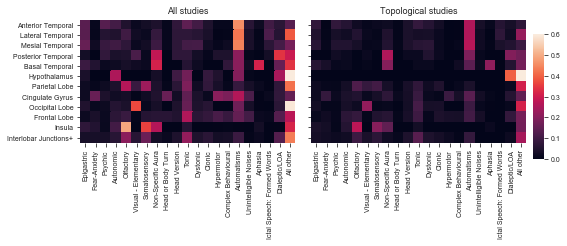

In [356]:
sns.set_style('ticks')
fig, axs = plt.subplots(1, 2, figsize=(7.5, 3), sharey=True, sharex=True)
cbar_ax = fig.add_axes([0.99, .3, .02, 0.576])
cbar_ax.patch.set_edgecolor('black')  
cbar_ax.patch.set_linewidth('1')  

heatmap_kwargs = {
    'square': True,
#      'xticklabels': x_labels
#     'vmin': 0.0,
#     'vmax': 1.0,
}

sns.heatmap(processed_dfs['normalised']['full']['proportion'].T, ax=axs[0], cbar=False, **heatmap_kwargs)
sns.heatmap(processed_dfs['normalised']['topology']['proportion'].T, ax=axs[1], cbar=True, cbar_ax = cbar_ax, **heatmap_kwargs)

axs[0].set_yticklabels(labels.clean_localisations(processed_dfs['normalised']['topology']['proportion'].columns), rotation=0)
axs[0].set_xticklabels(labels.clean_semiologies(processed_dfs['normalised']['topology']['proportion'].index))
axs[0].set_title('All studies')
axs[1].set_title('Topological studies')

# fig.colorbar(im, orientation="horizontal", pad=0.2)

plt.tight_layout()
# plt.savefig('/Users/karan/Downloads/heatmap4.png', dpi=300, pad_inches=0.5, bbox_inches = "tight")

# Region-specific subplots

- Q - use full, SS or topology?

In [358]:
def get_specific_df(query_results, columns_of_interest):
    counts_matrix = []
    for semiology, value in query_results.items():
        query_inspection = value['query_inspection']
        semiology_counts = query_inspection[columns_of_interest].sum().values
        counts_matrix.append(semiology_counts)
    counts_df = pd.DataFrame(counts_matrix, index=query_results.keys(), columns=columns_of_interest)
    return counts_df

In [ ]:
axis = 'zone'
normalised_or_not = 'normalised'

In [390]:
#Cingulate
cing_processed_dfs = {}
columns_of_interest = ['CING', 'Ant Cing (frontal, genu)', 'Post Cing', ]
for query_result_name, query_result in query_results[normalised_or_not].items():
    counts_df = get_specific_df(query_result, columns_of_interest)
    counts_df['Cingulate - (anterior + posterior)'] = counts_df['CING'] - (counts_df['Post Cing'] + counts_df['Ant Cing (frontal, genu)'])
    counts_df = interogate_queries.merge_all_other_semiologies(counts_df, sorted_semiologies[-20:])
    proportion_df = interogate_queries.calculate_proportions(counts_df, axis)
    confint_dfs = interogate_queries.calculate_confint(counts_df, axis = axis, method = 'binomial', alpha=0.05)
    cing_processed_dfs[query_result_name] = {
        'counts': counts_df,
        'proportion': proportion_df,
        'confints': confint_dfs
    }

In [391]:
# SMA
sma_processed_dfs = {}
columns_of_interest = ['SSMA', 'SMA (pre-central gyrus; posterior SFG, MFG)', 'FL']
for query_result_name, query_result in query_results[normalised_or_not].items():
    counts_df = get_specific_df(query_result, columns_of_interest)
    counts_df['SMA'] = counts_df['SSMA'] + counts_df['SMA (pre-central gyrus; posterior SFG, MFG)']
    counts_df['FL-SMA'] = counts_df['FL'] - counts_df['SMA']
    counts_df = counts_df.drop(['SMA (pre-central gyrus; posterior SFG, MFG)', 'SSMA'], 1)
    counts_df = interogate_queries.merge_all_other_semiologies(counts_df, sorted_semiologies[-20:])
    proportion_df = interogate_queries.calculate_proportions(counts_df, axis)
    confint_dfs = interogate_queries.calculate_confint(counts_df, axis = axis, method = 'binomial', alpha=0.05)
    sma_processed_dfs[query_result_name] = {
        'counts': counts_df,
        'proportion': proportion_df,
        'confints': confint_dfs
    }

In [392]:
# PL
pl_processed_dfs = {}
columns_of_interest = ['PL',
                       'Primary Sensory Cortex (post-central gyrus)',
                       'medial anterior parietal',
                       'Sup. pariet. lobule',
                       'Inferior Parietal Lobule',]
for query_result_name, query_result in query_results[normalised_or_not].items():
    counts_df = get_specific_df(query_result, columns_of_interest)
    counts_df = interogate_queries.merge_all_other_semiologies(counts_df, sorted_semiologies[-20:])
    proportion_df = interogate_queries.calculate_proportions(counts_df, axis)
    confint_dfs = interogate_queries.calculate_confint(counts_df, axis = axis, method = 'binomial', alpha=0.05)
    pl_processed_dfs[query_result_name] = {
        'counts': counts_df,
        'proportion': proportion_df,
        'confints': confint_dfs
    }

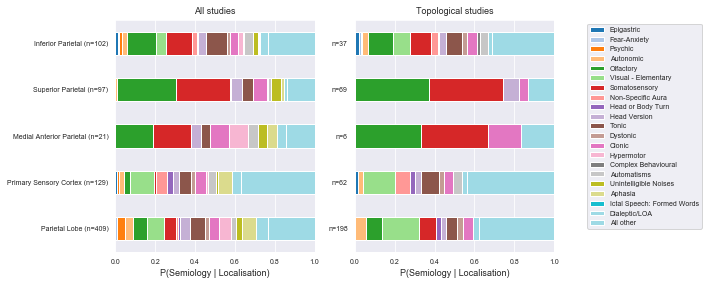

In [393]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(20, 2.5))

processed_dfs = copy.deepcopy(pl_processed_dfs)

y_labels = labels.clean_localisations(processed_dfs['full']['counts'].columns)
y_sums_1 = [int(n) for n in processed_dfs['full']['counts'].sum()]
y_sums_2 = [int(n) for n in processed_dfs['topology']['counts'].sum()]

combine_labels_1 = [label+f' (n={n})' for n, label in zip(y_sums_1, y_labels)]
n_labels_1 = [f'n={n}' for n in y_sums_1]
n_labels_2 = [f'n={n}' for n in y_sums_2]

plot_stacked_hbar(processed_dfs['full']['proportion'], ax=axs[0], ax_title='All studies', axis=axis, color_palette=color_palette)
plot_stacked_hbar(processed_dfs['topology']['proportion'], ax=axs[1], ax_title='Topological studies', axis=axis, color_palette=color_palette)

axs[0].get_legend().remove()
axs[0].set_yticklabels(combine_labels_1)
axs[1].set_yticklabels(n_labels_2)
axs[1].legend(bbox_to_anchor=(1.15,1), loc="upper left", labels=labels.clean_semiologies(processed_dfs['topology']['proportion'].index))

plt.tight_layout()
plt.savefig('/Users/karan/Downloads/PL.png', dpi=300, pad_inches=0.5)

---
# Figure 3: Odds ratio
---

Odds of semiology 1 localising to lobe A, divided by odds of NotSemiology A localising to lobe A. NotSemiology can be obtained by removing the result of QUERY_SEMIOLOGY from the original_df.
This gives Relative localising values. Interpret as intrinsic values of a specific semiology vs other semiologies. Narrow clinical history question.

In [462]:
axis='semiology'
regions_of_interest = region_names['low_level_temporal_of_interest']+region_names['of_interest_minus_tl']
semiologies_of_interest = sorted_semiologies

processed_dfs = {}
for normalised_or_not, sub_query_results in query_results.items():
    processed_dfs[normalised_or_not] = {}
    for study_type, query_result in sub_query_results.items():
        processed_dfs[normalised_or_not][study_type] = interogate_queries.summarise_query(
            query_result,
            axis = 'semiology',
            region_names = region_names,
            confint_method = 'binomial',
            merge_temporal = False,
            other_regions_included = True,
            semiologies_of_interest = semiologies_of_interest,
            regions_of_interest = regions_of_interest,
            drop_other_semiology = False)

/Users/karan/anaconda3/envs/semiology-vis/lib/python3.9/site-packages/statsmodels/stats/proportion.py:90: RuntimeWarning: invalid value encountered in true_divide
  q_ = count * 1. / nobs
/Users/karan/anaconda3/envs/semiology-vis/lib/python3.9/site-packages/statsmodels/stats/proportion.py:135: RuntimeWarning: divide by zero encountered in double_scalars
  denom = 1 + crit2 / nobs
/Users/karan/anaconda3/envs/semiology-vis/lib/python3.9/site-packages/statsmodels/stats/proportion.py:136: RuntimeWarning: divide by zero encountered in double_scalars
  center = (q_ + crit2 / (2 * nobs)) / denom
/Users/karan/anaconda3/envs/semiology-vis/lib/python3.9/site-packages/statsmodels/stats/proportion.py:137: RuntimeWarning: divide by zero encountered in double_scalars
  dist = crit * np.sqrt(q_ * (1. - q_) / nobs + crit2 / (4. * nobs**2))


In [ ]:
def get_contingency_from_data(df, specialty, religion):
    """
    see supplementary materials. 
    in the form:
    [[a, b],
     [c, d]]
    """
    a = df.loc[specialty, religion]
    b = df[religion].sum() - a
    c = df.loc[specialty, :].sum() - a
    d = (df.sum().sum() - df.loc[specialty, :].sum()) - b
    
    contingency_table = np.array(
        [[a, b],
        [c, d]]
    )
    
    chi2, p, dof, exp = chi2_contingency(contingency_table)
    
    ct = Table2x2(contingency_table)
    RR = ct.riskratio 
    OR = ct.oddsratio
    CI = ct.riskratio_confint()
    OR_CI = ct.oddsratio_confint()
    
    print('RR', round(RR, 2), '95% CI', round(CI[0], 2), round(CI[1], 2))
    print ('chi2', round(chi2, 1), 'p', p, 'dof', dof)
    return contingency_table, chi2, p, dof, exp, OR, OR_CI

In [513]:
total_row = normalised_raw_dfs['full'][regions_of_interest].sum()
total_row['All other'] = normalised_raw_dfs['full'][region_names['top_level_all_other']].sum().sum()

In [514]:
counts = processed_dfs['normalised']['full']['counts']

In [515]:
melted = counts.reset_index().melt(id_vars='index')
melted = melted.rename(columns={'index': 'semiology', 'variable': 'localisation', 'value': 'a'})
melted['localisation_total'] = np.zeros(len(melted))
for localisation, total in total_row.to_dict().items():
    mask = melted['localisation'] == localisation
    melted.loc[mask, 'localisation_total'] = total

In [516]:
melted['c'] = melted['localisation_total'] - melted['a']

In [517]:
melted['semiology_total'] = np.zeros(len(melted))
for semiology, total in counts.sum(1).to_dict().items():
    mask = melted['semiology'] == semiology
    melted.loc[mask, 'semiology_total'] = total

In [518]:
# melted['b+d (NOT localisation)'] = np.repeat(total_row.sum(), len(melted))  - melted['localisation_total'] 

In [519]:
melted['b'] = melted['semiology_total']-melted['a']

In [520]:
melted['d'] = np.repeat(total_row.sum(), len(melted)) - (melted['a'] + melted['b'] + melted['c'])

In [521]:
melted['OR'] = np.nan
melted['OR_lower_ci'] = np.nan
melted['OR_upper_ci'] = np.nan

In [522]:
for i in melted.index:
    contingency_table = Table2x2(
    [[melted.loc[i, 'a'], melted.loc[i, 'b']],
     [melted.loc[i, 'c'], melted.loc[i, 'd']]] )
      
    melted.loc[i, 'OR'] = contingency_table.oddsratio
    melted.loc[i, 'OR_lower_ci'] = contingency_table.oddsratio_confint(alpha = 0.05)[0]
    melted.loc[i, 'OR_upper_ci'] = contingency_table.oddsratio_confint(alpha = 0.05)[1]
    

In [526]:
or_pivot = melted.pivot_table(index=['semiology',], columns='localisation', values='OR')
or_l_pivot = melted.pivot_table(index=['semiology',], columns='localisation', values='OR_lower_ci')
or_u_pivot = melted.pivot_table(index=['semiology',], columns='localisation', values='OR_upper_ci')

In [531]:
or_pivot.loc[sorted_semiologies[-9:]]

localisation,All other,Anterior (temporal pole),Basal (including Fusiform OTMG),CING,FL,Hypothalamus,INSULA,Lateral Temporal,Mesial Temporal,OL,PL,Posterior Temporal
semiology,,,,,,,,,,,,
Somatosensory,1.997708,0.233198,0.165421,0.242463,0.491849,0.031050,30.410372,0.169064,0.186737,0.112337,2.898464,0.128586
Dystonic,0.711428,1.457490,0.271285,0.539242,0.788182,0.042326,0.010800,0.853649,1.859203,0.573211,0.319583,0.354298
Dialeptic/LOA,1.699926,0.636434,1.779258,0.850119,1.500183,2.634769,0.045343,0.677997,1.312187,0.687405,0.881292,4.018521
Autonomous-Vegetative,0.695792,1.086898,0.210222,0.265589,0.612412,2.521209,2.594457,0.521862,0.999137,0.537573,0.491728,0.368572
Epigastric,0.348101,1.273512,0.790293,0.182176,0.138198,0.290340,1.399179,1.381758,1.869537,0.411545,0.195080,0.235399
Non-Specific Aura,0.293039,0.323196,3.260659,0.427636,0.489816,0.234631,10.812103,0.781386,0.778555,0.296224,0.420652,2.577653
Tonic,1.956108,0.983889,0.381256,1.056752,2.167965,1.040115,0.793581,0.491348,0.614524,1.084445,1.552104,0.436162
Olfactory,1.621708,0.243885,0.209618,0.196638,0.471261,0.019410,32.991874,0.637683,0.323901,0.237560,2.095253,0.246237
Automatisms Combination - Manual LowerLimb Oral,0.273302,1.800169,0.580627,0.788296,0.353282,0.464381,0.010667,1.703653,2.042149,0.441755,0.234166,0.532303


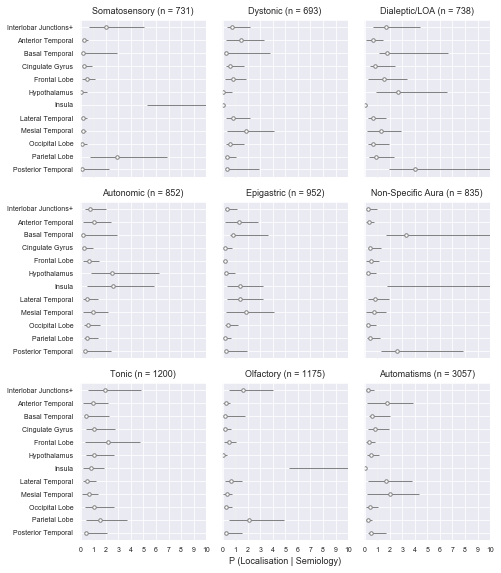

In [547]:
sns.set_style('darkgrid')
plotter_functions. plot_proportion_ci_forest_plot(proportion_df_1 = or_pivot.loc[sorted_semiologies[-9:]],
                               confint_df_1 = (or_l_pivot.loc[sorted_semiologies[-9:]], or_u_pivot.loc[sorted_semiologies[-9:]]),
                               counts_df_1 = processed_dfs['not_normalised']['full']['counts'],
                               colors = colors,
                               legend_labels = legend_labels,
                               proportion_df_2 = None,
                               confint_df_2 = None,
                               counts_df_2 = None,
                               y_labels = labels.clean_localisations(or_pivot.loc[sorted_semiologies[-9:]].columns),
                               overlapping=False,
                               ax_titles = labels.clean_semiologies(or_pivot.loc[sorted_semiologies[-9:]].index),
                               xlim = [-0.05,10],
                                   xticks = np.arange(0, 11, 1),
                                   vline = 1.0,
                               plotter_settings = plotter_settings,
                              )

# plt.savefig('.png', dpi=300, pad_inches=0.5)

In [545]:
reload(plotter_functions)

<module 'scripts.figures.plotter_functions' from '/Volumes/Encrypted/Semiology-Visualisation-Tool/scripts/figures/plotter_functions.py'>

# NMI/Correlation

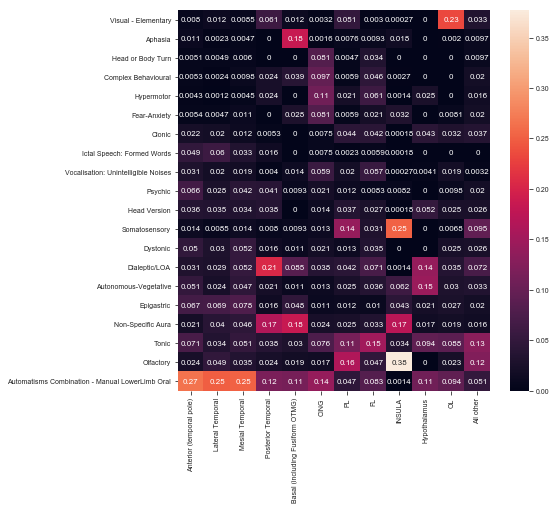

In [836]:
# sns.set_style('ticks')
# fig, axs = plt.subplots(1, 1, figsize=(7.5, 8), sharey=True, sharex=True)
# cbar_ax = fig.add_axes([0.99, .3, .02, 0.576])
# cbar_ax.patch.set_edgecolor('black')  
# cbar_ax.patch.set_linewidth('1')  

# heatmap_kwargs = {
#     'square': True,
# }
sns.set_style('ticks')
fig, ax = plt.subplots(1, figsize=(7, 7))
sns.heatmap(odds.loc[semiologies_of_interest], cbar=True, annot=True)

# axs.set_yticklabels(region_names['roi_clean_labels'], rotation=0)
# axs.set_title('All studies')

# # fig.colorbar(im, orientation="horizontal", pad=0.2)

# plt.tight_layout()
# plt.savefig('/Users/karan/Downloads/heatmap4.png', dpi=300, pad_inches=0.5, bbox_inches = "tight")

In [775]:
import dython

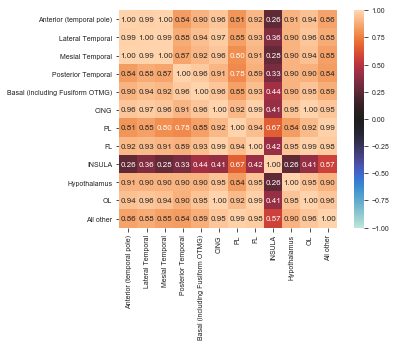

{'corr':                                  Anterior (temporal pole)  Lateral Temporal  \
 Anterior (temporal pole)                         1.000000          0.990158   
 Lateral Temporal                                 0.990158          1.000000   
 Mesial Temporal                                  0.995901          0.994472   
 Posterior Temporal                               0.840019          0.875255   
 Basal (including Fusiform OTMG)                  0.900717          0.935554   
 CING                                             0.958614          0.970846   
 PL                                               0.814266          0.848953   
 FL                                               0.917838          0.926684   
 INSULA                                           0.262681          0.355559   
 Hypothalamus                                     0.905641          0.902420   
 OL                                               0.943314          0.956764   
 All other                      

In [777]:
dython.nominal.associations(counts, theil_u=True)

----
## Junk
----